In [23]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [24]:
with h5py.File('../data/lotka_volterra_data.h5', 'r') as f:
    trajectories = f['trajectories'][:]  # Shape: (1000, 100, 2)
    time_points = f['time'][:]           # Shape: (100,)
    
    print("Dataset shape:", trajectories.shape)
    print("Time points shape:", time_points.shape)
    print("First few time points:", time_points[:5])


Dataset shape: (1000, 100, 2)
Time points shape: (100,)
First few time points: [0.         2.02020202 4.04040404 6.06060606 8.08080808]


## Sample trajectories of prey and predator populations over time

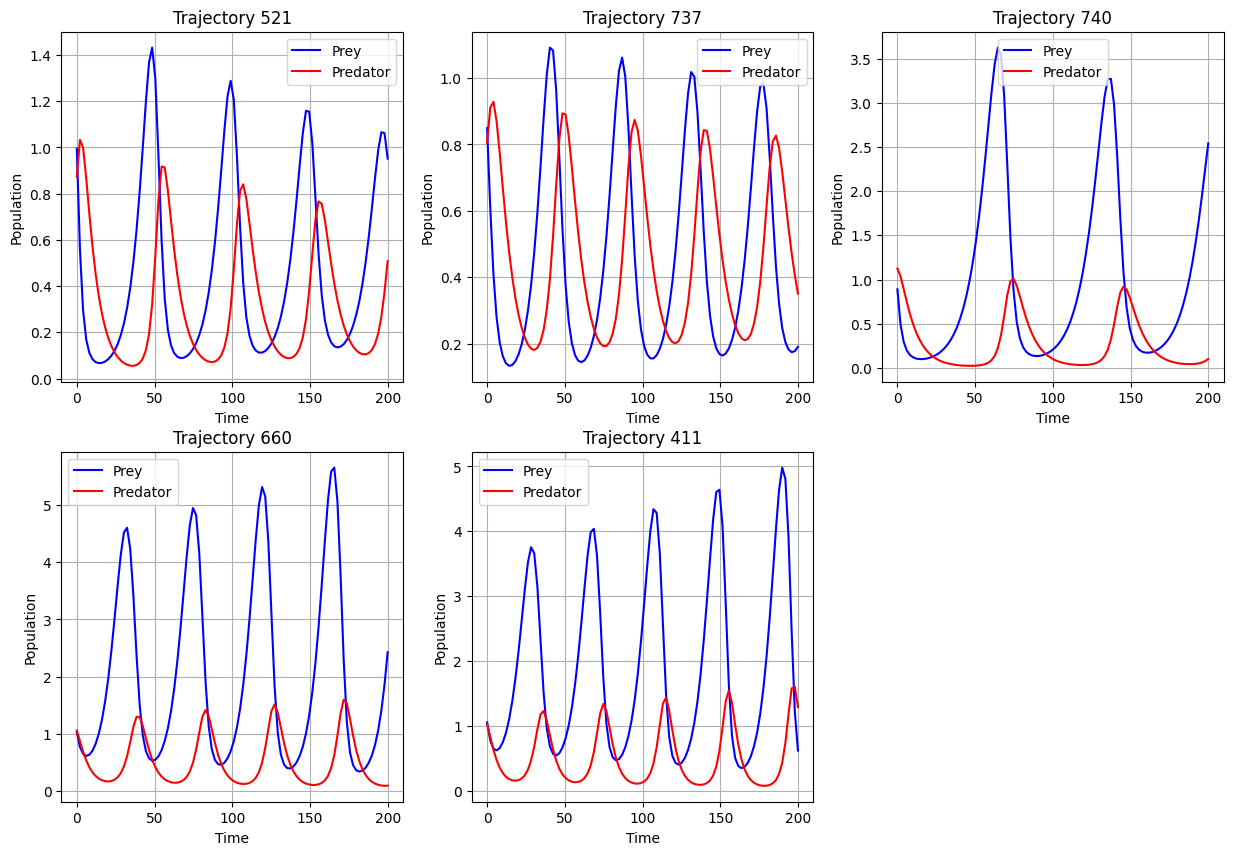

In [25]:
# Plot a few example trajectories
plt.figure(figsize=(15, 10))

# Plot 5 random trajectories
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(trajectories.shape[0], 5, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+1)
    plt.plot(time_points, trajectories[idx, :, 0], 'b-', label='Prey')
    plt.plot(time_points, trajectories[idx, :, 1], 'r-', label='Predator')
    plt.title(f'Trajectory {idx}')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

## Phase portrait showing the relationship between prey and predator populations

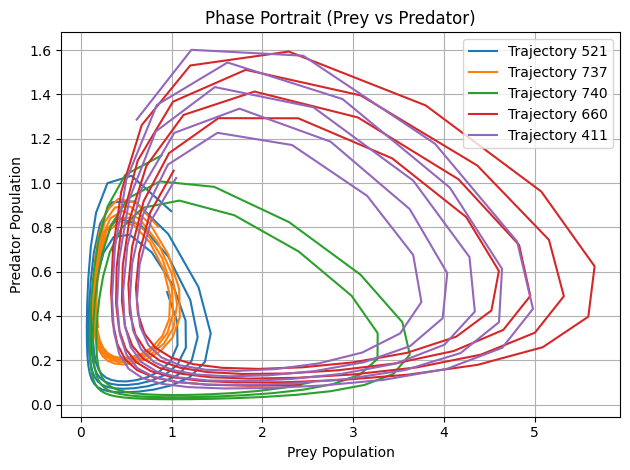

In [26]:
# Plot the phase portrait for the first example
for idx in sample_indices:
    plt.plot(trajectories[idx, :, 0], trajectories[idx, :, 1])
plt.title('Phase Portrait (Prey vs Predator)')
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.legend([f'Trajectory {idx}' for idx in sample_indices])
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
# Calculate statistics across all trajectories
prey_mean = np.mean(trajectories[:, :, 0], axis=0)
prey_std = np.std(trajectories[:, :, 0], axis=0)
pred_mean = np.mean(trajectories[:, :, 1], axis=0)
pred_std = np.std(trajectories[:, :, 1], axis=0)

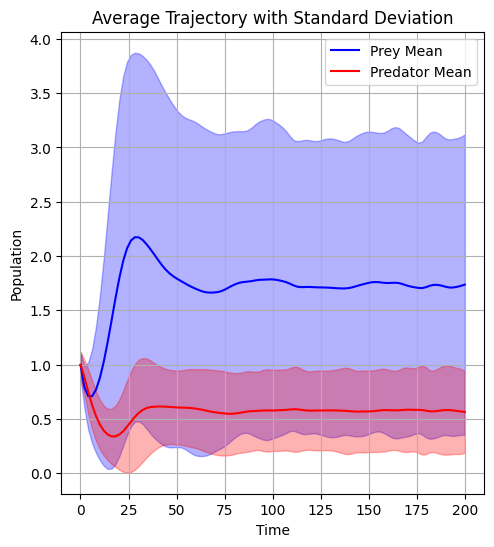

In [28]:
# Plot the average trajectory with standard deviation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time_points, prey_mean, 'b-', label='Prey Mean')
plt.fill_between(time_points, prey_mean - prey_std, prey_mean + prey_std, alpha=0.3, color='blue')
plt.plot(time_points, pred_mean, 'r-', label='Predator Mean')
plt.fill_between(time_points, pred_mean - pred_std, pred_mean + pred_std, alpha=0.3, color='red')
plt.title('Average Trajectory with Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)


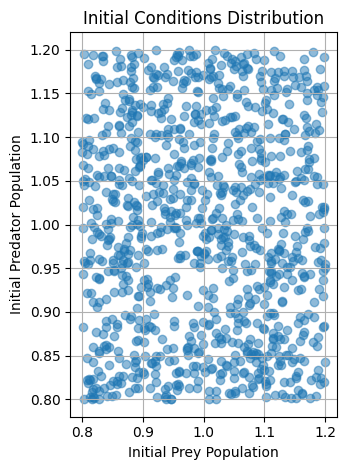

In [33]:
# Plot distribution of initial conditions
plt.subplot(1, 2, 2)
plt.scatter(trajectories[:, 0, 0], trajectories[:, 0, 1], alpha=0.5)
plt.title('Initial Conditions Distribution')
plt.xlabel('Initial Prey Population')
plt.ylabel('Initial Predator Population')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Plot distribution of initial conditions
plt.subplot(1, 2, 2)
plt.scatter(trajectories[:, -1, 0], trajectories[:, -1, 1], alpha=0.5)
plt.title('Final Distribution')
plt.xlabel('Final Prey Population')
plt.ylabel('Final Predator Population')
plt.grid(True)

plt.tight_layout()
plt.show()

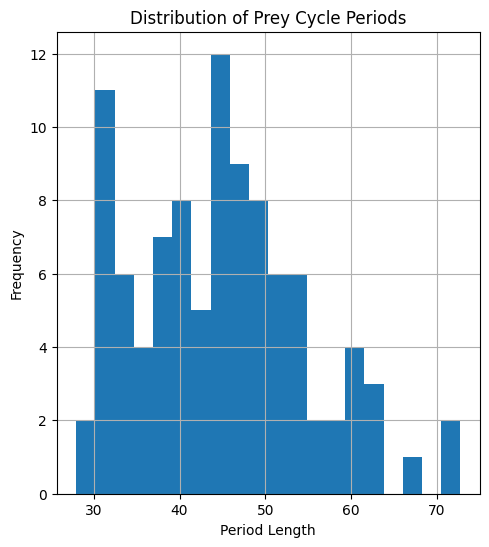

In [30]:
plt.figure(figsize=(12, 6))

# Find periods for prey populations
periods = []
for i in range(min(100, trajectories.shape[0])):  # Use first 100 trajectories
    # Find peaks
    peaks, _ = find_peaks(trajectories[i, :, 0], height=0)
    if len(peaks) >= 2:
        # Calculate average distance between peaks
        peak_diffs = np.diff(peaks)
        period = np.mean(peak_diffs) * (time_points[1] - time_points[0])
        periods.append(period)

plt.subplot(1, 2, 1)
plt.hist(periods, bins=20)
plt.title('Distribution of Prey Cycle Periods')
plt.xlabel('Period Length')
plt.ylabel('Frequency')
plt.grid(True)


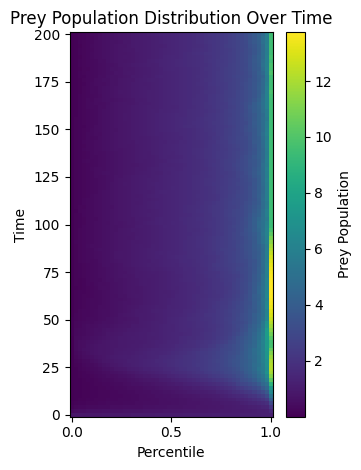

In [31]:
# Plot a heatmap of population dynamics over time
plt.subplot(1, 2, 2)
plt.pcolormesh(np.linspace(0, 1, 50), time_points, 
               np.percentile(trajectories[:, :, 0], np.linspace(0, 100, 50), axis=0).T)
plt.title('Prey Population Distribution Over Time')
plt.xlabel('Percentile')
plt.ylabel('Time')
plt.colorbar(label='Prey Population')

plt.tight_layout()
plt.show()